# Monte Carlo Simulations

This is an advanced use of RocketPy. This notebook wraps RocketPy's methods to run a Monte Carlo analysis and predict probability distributions of the rocket's landing point, apogee and other relevant information.

The main output is a map very similar to the one below.

![Landing point dispersion elipses](https://github.com/RocketPy-Team/RocketPy/raw/master/docs/notebooks/dispersion_analysis/dispersion_analysis_outputs/valetudo_rocket_v0.svg)

This jupyter notebook presents the Monte Carlo analysis performed for the flight of Valetudo, one of the most famous rockets made by Projeto Jupiter. Valetudo has a diameter of $80$ mm and height of $2.4$ m. It was built for the first time to be launched at Latin American Space Challenge (LASC) 2019. Indeed, Valetudo came to be launched in 2019 on August 10th by 5:56 pm (local time), propelled by a class K motor called 'Keron', a solid motor completely designed and built by Projeto Jupiter. The rocket crossed the sky and reached an $860$ m apogee, descending safely by the drogue parachute called "Charmander" and landing with an 18.5 m/s terminal velocity. 

We hope you enjoy the flight(s) in this notebook just like everyone in LASC19 did it in real-time!

**NOTE:** There is a new `MonteCarlo` class in RocketPy v1.2.0. This notebook is still here just for reference, but it is recommended to use the new class. See the `Monte Carlo class usage` page in the documentation for more information.

## Download data files if using Google Colab

If you are running this using Binder, or you are running locally with the necessary files, you do not need to run this.
On the other hand, if you are running on Google Colab, make sure to run the cell below to download the necessary files.

In [ ]:
!curl -o dispersion_analysis_inputs/Cd_PowerOff.csv --create-dirs https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/Cd_PowerOff.csv
!curl -o dispersion_analysis_inputs/Cd_PowerOn.csv --create-dirs https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/Cd_PowerOn.csv
!curl -o dispersion_analysis_inputs/LASC2019_reanalysis.nc --create-dirs https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/LASC2019_reanalysis.nc
!curl -o dispersion_analysis_inputs/thrustCurve.csv --create-dirs https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/thrustCurve.csv
!curl -o dispersion_analysis_inputs/Valetudo_basemap_final.jpg --create-dirs https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/docs/notebooks/dispersion_analysis/dispersion_analysis_inputs/Valetudo_basemap_final.jpg
!mkdir -p dispersion_analysis_outputs

## Install and Load Necessary Libraries



In [ ]:
!pip install rocketpy imageio

In [1]:
from time import process_time, time

from rocketpy import Environment, SolidMotor, Rocket, Flight

import numpy as np
from numpy.random import normal, choice
from IPython.display import display

Next, we import matplotlib to produce awesome looking plots.

In [2]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

## Defining Analysis Parameters

The analysis parameters are a collection of expected values (and their uncertainties, or standard deviation) that completely defines a rocket flight.
As an assumption, the parameters which define the flight can behave in 3 different ways:
 - the parameter is a completely known and has a constant value (i.e. number of fins)
 - the parameter can assume certain discrete values with uniform distribution (i.e. the member of an ensemble forecast, which might be any integer from 0 to 9)
 - the parameter is best represented by a normal (gaussian) distribution with a defined expected value and standard deviation

We implement this using a dictionary, where the key is the name of the parameter and the value is either a tuple or a list, depending on the behaviour of the parameter:
 - if the parameter is know, its value is represented as a list with a single entry (i.e. `"number_of_fins: [4]"`)
 - if the parameter can assume certain discrete values with uniform distribution, its values are represented by a list of possible choices (i.e. `"member_of_ensemble_forecast: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"`)
 - if the parameter is best represented by a normal (gaussian) distribution, its value is a tuple with the expected value and its standard deviation (i.e. `"rocket_mass": (100, 2)`, where 100 kg is the expected mass, with uncertainty of plus or minus 2 kg)

In [3]:
analysis_parameters = {
    # Mass Details
    # Rocket's dry mass without motor (kg) and its uncertainty (standard deviation)
    "rocket_mass": (7.257, 0.001),
    # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "rocket_inertia_11": (3.675, 0.03675),
    # Rocket's inertia moment relative to its axis (kg*m^2)
    "rocket_inertia_33": (0.007, 0.00007),
    # Motors's dry mass without propellant (kg) and its uncertainty (standard deviation)
    "motor_dry_mass": (1.000, 0.001),
    # Motor's dry inertia moment perpendicular to its axis (kg*m^2)
    "motor_inertia_11": (1.675, 0.01675),
    # Motors's dry inertia moment relative to its axis (kg*m^2)
    "motor_inertia_33": (0.003, 0.00003),
    # Distance between rocket's center of dry mass and motor's center of dry mass (m)
    "motor_dry_mass_position": (0.5, 0.001),
    # Propulsion Details - run help(SolidMotor) for more information
    # Motor total impulse (N*s)
    "impulse": (1415.15, 35.3),
    # Motor burn out time (s)
    "burn_time": (5.274, 1),
    # Motor's nozzle radius (m)
    "nozzle_radius": (21.642 / 1000, 0.5 / 1000),
    # Motor's nozzle throat radius (m)
    "throat_radius": (8 / 1000, 0.5 / 1000),
    # Motor's grain separation (axial distance between two grains) (m)
    "grain_separation": (6 / 1000, 1 / 1000),
    # Motor's grain density (kg/m^3)
    "grain_density": (1707, 50),
    # Motor's grain outer radius (m)
    "grain_outer_radius": (21.4 / 1000, 0.375 / 1000),
    # Motor's grain inner radius (m)
    "grain_initial_inner_radius": (9.65 / 1000, 0.375 / 1000),
    # Motor's grain height (m)
    "grain_initial_height": (120 / 1000, 1 / 1000),
    # Aerodynamic Details - run help(Rocket) for more information
    # Rocket's radius (kg*m^2)
    "radius": (40.45 / 1000, 0.001),
    # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "nozzle_position": (-1.024, 0.001),
    # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "grains_center_of_mass_position": (-0.571, 0.001),
    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_off_drag": (0.9081 / 1.05, 0.033),
    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_on_drag": (0.9081 / 1.05, 0.033),
    # Rocket's nose cone length (m)
    "nose_length": (0.274, 0.001),
    # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "nose_distance_to_CM": (1.134, 0.001),
    # Fin span (m)
    "fin_span": (0.077, 0.0005),
    # Fin root chord (m)
    "fin_root_chord": (0.058, 0.0005),
    # Fin tip chord (m)
    "fin_tip_chord": (0.018, 0.0005),
    # Axial distance between rocket's center of dry mass and nearest point in its fin (m)
    "fin_distance_to_CM": (-0.906, 0.001),
    # Launch and Environment Details - run help(Environment) and help(Flight) for more information
    # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (84.7, 1),
    # Launch rail heading relative to north (degrees)
    "heading": (53, 2),
    # Launch rail length (m)
    "rail_length": (5.7, 0.0005),
    # Members of the ensemble forecast to be used
    "ensemble_member": list(range(10)),
    # Parachute Details - run help(Rocket) for more information
    # Drag coefficient times reference area for the drogue chute (m^2)
    "cd_s_drogue": (0.349 * 1.3, 0.07),
    # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    "lag_rec": (1, 0.5),
    # Electronic Systems Details - run help(Rocket) for more information
    # Time delay between sensor signal is received and ejection signal is fired (s)
    "lag_se": (0.73, 0.16),
}

## Creating a Flight Settings Generator

Now, we create a generator function which will yield all the necessary inputs for a single flight simulation. Each generated input will be randomly generated according to the `analysis_parameters` dicitionary set up above.

This is just a helper function to make the code clearer.

In [4]:
def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] = normal(*parameter_value)
            else:
                flight_setting[parameter_key] = choice(parameter_value)

        # Skip if certain values are negative, which happens due to the normal curve but isnt realistic
        if flight_setting["lag_rec"] < 0 or flight_setting["lag_se"] < 0:
            continue

        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

## Creating an Export Function

Monte Carlo analyses usually contain data from thousands or tens of thousands of simulations. They can easily take hours to run. Therefore, it is very important to save our outputs to a file during the analysis. This way, if something happens, we do not lose our progress.

These next functions take care of that. They export the simulation data to three different files:
- `dispersion_input_file`: A file where each line is a json converted dictionary of flight setting inputs to run a single trajectory simulation;
- `dispersion_output_file`: A file where each line is a json converted dictionary containing the main outputs of a single simulation, such as apogee altitute and maximum velocity;
- `dispersion_error_file`: A file to store the inputs of simulations which raised errors. This can help us debug these simulations later on.

In [5]:
def export_flight_data(flight_setting, flight_data, exec_time):
    # Generate flight results
    flight_result = {
        "out_of_rail_time": flight_data.out_of_rail_time,
        "out_of_rail_velocity": flight_data.out_of_rail_velocity,
        "max_velocity": flight_data.speed.max,
        "apogee_time": flight_data.apogee_time,
        "apogee_altitude": flight_data.apogee - Env.elevation,
        "apogee_x": flight_data.apogee_x,
        "apogee_y": flight_data.apogee_y,
        "impact_time": flight_data.t_final,
        "impact_x": flight_data.x_impact,
        "impact_y": flight_data.y_impact,
        "impact_velocity": flight_data.impact_velocity,
        "initial_static_margin": flight_data.rocket.static_margin(0),
        "out_of_rail_static_margin": flight_data.rocket.static_margin(
            flight_data.out_of_rail_time
        ),
        "final_static_margin": flight_data.rocket.static_margin(
            flight_data.rocket.motor.burn_out_time
        ),
        "number_of_events": len(flight_data.parachute_events),
        "execution_time": exec_time,
    }

    # Take care of parachute results
    if len(flight_data.parachute_events) > 0:
        flight_result["drogue_triggerTime"] = flight_data.parachute_events[0][0]
        flight_result["drogue_inflated_time"] = (
            flight_data.parachute_events[0][0] + flight_data.parachute_events[0][1].lag
        )
        flight_result["drogue_inflated_velocity"] = flight_data.speed(
            flight_data.parachute_events[0][0] + flight_data.parachute_events[0][1].lag
        )
    else:
        flight_result["drogue_triggerTime"] = 0
        flight_result["drogue_inflated_time"] = 0
        flight_result["drogue_inflated_velocity"] = 0

    # Write flight setting and results to file
    dispersion_input_file.write(str(flight_setting) + "\n")
    dispersion_output_file.write(str(flight_result) + "\n")


def export_flight_error(flight_setting):
    dispersion_error_file.write(str(flight_setting) + "\n")

## Simulating Each Flight Setting

Finally, we can start running some simulations!

We start by defining the file name we want to use. Then, we specifiy how many simulations we would like to run by setting the `number_of_simulations` variable.

It is good practice to run something in the order of 100 simulations first, to check for any possible errors in the code. Once we are confident that everything is working well, we increase the number of simulations to something in the range of 5000 to 50000.

We will loop throught all flight settings, creating the environment, rocket and motor classes with the data of the analysis parameters.
For the power off and on drag and thrust curve user should have in hands the .csv (or .eng for comercial motor's thrust curve).

**Tip**: A better practice is openning the files in "append" mode, this way we can acumulate our simulations. To do this, just change the 'a' (write) argument of the `open` function in the third, fourth and fifth line of code to `a` (append).

In [6]:
# Basic analysis info
filename = "monte_carlo_analysis_outputs/valetudo_rocket_v0"
number_of_simulations = 100

# Create data files for inputs, outputs and error logging
dispersion_error_file = open(str(filename) + ".disp_errors.txt", "w")
dispersion_input_file = open(str(filename) + ".disp_inputs.txt", "w")
dispersion_output_file = open(str(filename) + ".disp_outputs.txt", "w")

# Initialize counter and timer
i = 0

initial_wall_time = time()
initial_cpu_time = process_time()

# Define basic Environment object
Env = Environment(date=(2019, 8, 10, 21), latitude=-23.363611, longitude=-48.011389)
Env.set_elevation(668)
Env.max_expected_height = 1500
Env.set_atmospheric_model(
    type="Ensemble",
    file="monte_carlo_analysis_inputs/LASC2019_reanalysis.nc",
    dictionary="ECMWF",
)


# Set up parachutes. This rocket, named Valetudo, only has a drogue chute.
def drogue_trigger(p, h, y):
    # Check if rocket is going down, i.e. if it has passed the apogee
    vertical_velocity = y[5]
    # Return true to activate parachute once the vertical velocity is negative
    return True if vertical_velocity < 0 else False


# Iterate over flight settings
out = display("Starting", display_id=True)
for setting in flight_settings(analysis_parameters, number_of_simulations):
    start_time = process_time()
    i += 1

    # Update environment object
    Env.select_ensemble_member(setting["ensemble_member"])

    # Create motor
    Keron = SolidMotor(
        thrust_source="monte_carlo_analysis_inputs/thrustCurve.csv",
        burn_time=5.274,
        reshape_thrust_curve=(setting["burn_time"], setting["impulse"]),
        nozzle_radius=setting["nozzle_radius"],
        throat_radius=setting["throat_radius"],
        grain_number=6,
        grain_separation=setting["grain_separation"],
        grain_density=setting["grain_density"],
        grain_outer_radius=setting["grain_outer_radius"],
        grain_initial_inner_radius=setting["grain_initial_inner_radius"],
        grain_initial_height=setting["grain_initial_height"],
        interpolation_method="linear",
        coordinate_system_orientation="nozzle_to_combustion_chamber",
        nozzle_position=setting["nozzle_position"],
        grains_center_of_mass_position=setting["grains_center_of_mass_position"],
        dry_mass=setting["motor_dry_mass"],
        dry_inertia=(
            setting["motor_inertia_11"],
            setting["motor_inertia_11"],
            setting["motor_inertia_33"],
        ),
        center_of_dry_mass_position=setting["motor_dry_mass_position"],
    )
    # Create rocket
    Valetudo = Rocket(
        radius=setting["radius"],
        mass=setting["rocket_mass"],
        inertia=(
            setting["rocket_inertia_11"],
            setting["rocket_inertia_11"],
            setting["rocket_inertia_33"],
        ),
        power_off_drag="monte_carlo_analysis_inputs/Cd_PowerOff.csv",
        power_on_drag="monte_carlo_analysis_inputs/Cd_PowerOn.csv",
        center_of_mass_without_motor=0,
        coordinate_system_orientation="tail_to_nose",
    )
    Valetudo.set_rail_buttons(0.224, -0.93, 30)

    Valetudo.add_motor(Keron, position=0)

    # Edit rocket drag
    Valetudo.power_off_drag *= setting["power_off_drag"]
    Valetudo.power_on_drag *= setting["power_on_drag"]
    # Add rocket nose, fins and tail
    NoseCone = Valetudo.add_nose(
        length=setting["nose_length"],
        kind="vonKarman",
        position=setting["nose_distance_to_CM"] + setting["nose_length"],
    )
    FinSet = Valetudo.add_trapezoidal_fins(
        n=3,
        span=setting["fin_span"],
        root_chord=setting["fin_root_chord"],
        tip_chord=setting["fin_tip_chord"],
        position=setting["fin_distance_to_CM"],
        cant_angle=0,
        airfoil=None,
    )
    # Add parachute
    Drogue = Valetudo.add_parachute(
        "Drogue",
        cd_s=setting["cd_s_drogue"],
        trigger=drogue_trigger,
        sampling_rate=105,
        lag=setting["lag_rec"] + setting["lag_se"],
        noise=(0, 8.3, 0.5),
    )

    # Run trajectory simulation
    try:
        test_flight = Flight(
            rocket=Valetudo,
            environment=Env,
            rail_length=setting["rail_length"],
            inclination=setting["inclination"],
            heading=setting["heading"],
            max_time=600,
        )
        export_flight_data(setting, test_flight, process_time() - start_time)
    except Exception as E:
        print(E)
        export_flight_error(setting)

    # Register time
    out.update(
        f"Curent iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s"
    )

# Done

## Print and save total time
final_string = f"Completed {i} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
out.update(final_string)
dispersion_input_file.write(final_string + "\n")
dispersion_output_file.write(final_string + "\n")
dispersion_error_file.write(final_string + "\n")

## Close files
dispersion_input_file.close()
dispersion_output_file.close()
dispersion_error_file.close()

'Completed 100 iterations successfully. Total CPU time: 295.984375 s. Total wall time: 299.65940380096436 s'

## Post-processing Monte Carlo Dispersion Results

Now that we have finish running thousands of simulations, it is time to process the results and get some nice graphs out of them! 

### Importing Dispersion Analysis Saved Data

We start by loading the file which stores the outputs.

In [7]:
filename = "monte_carlo_analysis_outputs/valetudo_rocket_v0"

# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {
    "out_of_rail_time": [],
    "out_of_rail_velocity": [],
    "apogee_time": [],
    "apogee_altitude": [],
    "apogee_x": [],
    "apogee_y": [],
    "impact_time": [],
    "impact_x": [],
    "impact_y": [],
    "impact_velocity": [],
    "initial_static_margin": [],
    "out_of_rail_static_margin": [],
    "final_static_margin": [],
    "number_of_events": [],
    "max_velocity": [],
    "drogue_triggerTime": [],
    "drogue_inflated_time": [],
    "drogue_inflated_velocity": [],
    "execution_time": [],
}

# Get all dispersion results
# Get file
dispersion_output_file = open(str(filename) + ".disp_outputs.txt", "r+")

# Read each line of the file and convert to dict
for line in dispersion_output_file:
    # Skip comments lines
    if line[0] != "{":
        continue
    # Eval results and store them
    flight_result = eval(line)
    dispersion_general_results.append(flight_result)
    for parameter_key, parameter_value in flight_result.items():
        dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Print number of flights simulated
N = len(dispersion_general_results)
print("Number of simulations: ", N)

Number of simulations:  100


## Dispersion Results

Now, we plot the histogram for every single output. This shows how are outputs behave. Valuable statistical data can be calculated based on them.

### Out of Rail Time

Out of Rail Time -         Mean Value: 1.093 s
Out of Rail Time - Standard Deviation: 0.181 s


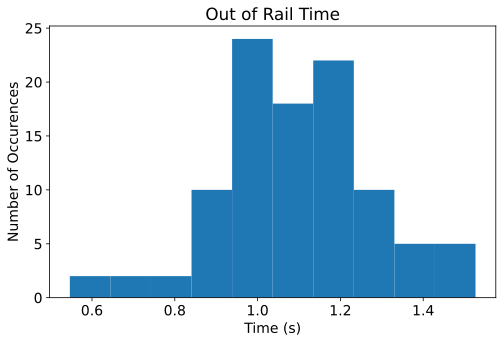

In [8]:
print(
    f'Out of Rail Time -         Mean Value: {np.mean(dispersion_results["out_of_rail_time"]):0.3f} s'
)
print(
    f'Out of Rail Time - Standard Deviation: {np.std(dispersion_results["out_of_rail_time"]):0.3f} s'
)

plt.figure()
plt.hist(dispersion_results["out_of_rail_time"], bins=int(N**0.5))
plt.title("Out of Rail Time")
plt.xlabel("Time (s)")
plt.ylabel("Number of Occurences")
plt.show()

### Out of Rail Velocity

Out of Rail Velocity -         Mean Value: 22.910 m/s
Out of Rail Velocity - Standard Deviation: 3.167 m/s


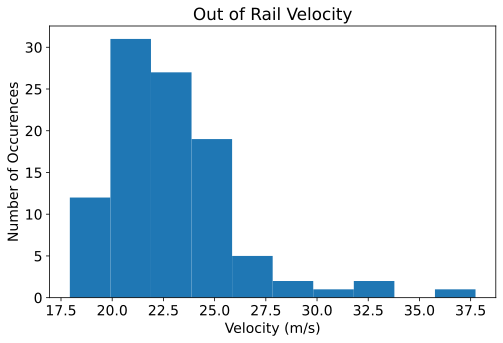

In [9]:
print(
    f'Out of Rail Velocity -         Mean Value: {np.mean(dispersion_results["out_of_rail_velocity"]):0.3f} m/s'
)
print(
    f'Out of Rail Velocity - Standard Deviation: {np.std(dispersion_results["out_of_rail_velocity"]):0.3f} m/s'
)

plt.figure()
plt.hist(dispersion_results["out_of_rail_velocity"], bins=int(N**0.5))
plt.title("Out of Rail Velocity")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Number of Occurences")
plt.show()

### Apogee Time

Apogee Time -         Mean Value: 14.275 s
Apogee Time - Standard Deviation: 0.353 s


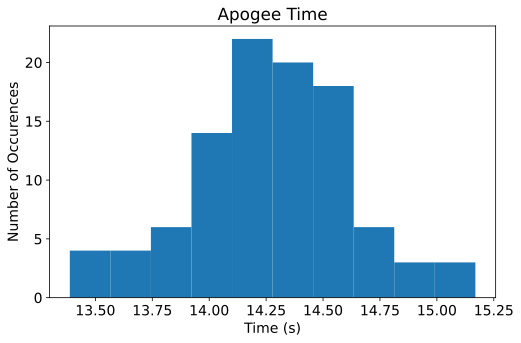

In [10]:
print(
    f'Apogee Time -         Mean Value: {np.mean(dispersion_results["apogee_time"]):0.3f} s'
)
print(
    f'Apogee Time - Standard Deviation: {np.std(dispersion_results["apogee_time"]):0.3f} s'
)

plt.figure()
plt.hist(dispersion_results["apogee_time"], bins=int(N**0.5))
plt.title("Apogee Time")
plt.xlabel("Time (s)")
plt.ylabel("Number of Occurences")
plt.show()

### Apogee Altitude

Apogee Altitude -         Mean Value: 840.500 m
Apogee Altitude - Standard Deviation: 42.109 m


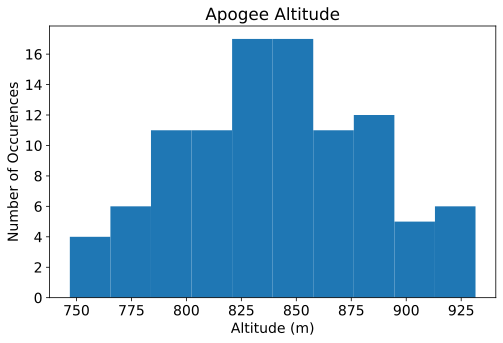

In [11]:
print(
    f'Apogee Altitude -         Mean Value: {np.mean(dispersion_results["apogee_altitude"]):0.3f} m'
)
print(
    f'Apogee Altitude - Standard Deviation: {np.std(dispersion_results["apogee_altitude"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["apogee_altitude"], bins=int(N**0.5))
plt.title("Apogee Altitude")
plt.xlabel("Altitude (m)")
plt.ylabel("Number of Occurences")
plt.show()

# Real measured apogee for Valetudo = 860 m

### Apogee X Position

Apogee X Position -         Mean Value: 112.849 m
Apogee X Position - Standard Deviation: 25.302 m


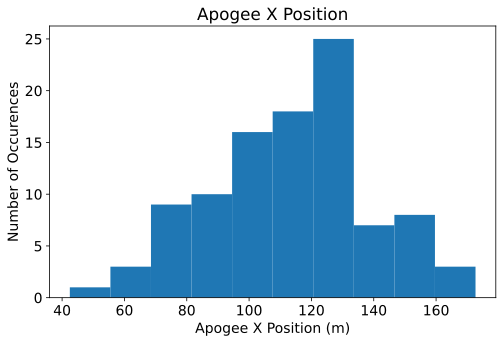

In [12]:
print(
    f'Apogee X Position -         Mean Value: {np.mean(dispersion_results["apogee_x"]):0.3f} m'
)
print(
    f'Apogee X Position - Standard Deviation: {np.std(dispersion_results["apogee_x"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["apogee_x"], bins=int(N**0.5))
plt.title("Apogee X Position")
plt.xlabel("Apogee X Position (m)")
plt.ylabel("Number of Occurences")
plt.show()

### Apogee Y Position

Apogee Y Position -         Mean Value: 100.625 m
Apogee Y Position - Standard Deviation: 19.627 m


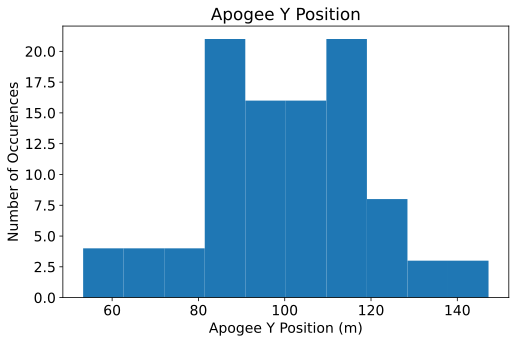

In [13]:
print(
    f'Apogee Y Position -         Mean Value: {np.mean(dispersion_results["apogee_y"]):0.3f} m'
)
print(
    f'Apogee Y Position - Standard Deviation: {np.std(dispersion_results["apogee_y"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["apogee_y"], bins=int(N**0.5))
plt.title("Apogee Y Position")
plt.xlabel("Apogee Y Position (m)")
plt.ylabel("Number of Occurences")
plt.show()

### Impact Time

Impact Time -         Mean Value: 63.790 s
Impact Time - Standard Deviation: 4.085 s


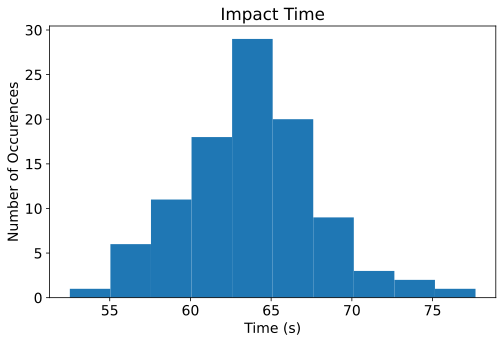

In [14]:
print(
    f'Impact Time -         Mean Value: {np.mean(dispersion_results["impact_time"]):0.3f} s'
)
print(
    f'Impact Time - Standard Deviation: {np.std(dispersion_results["impact_time"]):0.3f} s'
)

plt.figure()
plt.hist(dispersion_results["impact_time"], bins=int(N**0.5))
plt.title("Impact Time")
plt.xlabel("Time (s)")
plt.ylabel("Number of Occurences")
plt.show()

### Impact X Position

Impact X Position -         Mean Value: 374.140 m
Impact X Position - Standard Deviation: 50.154 m


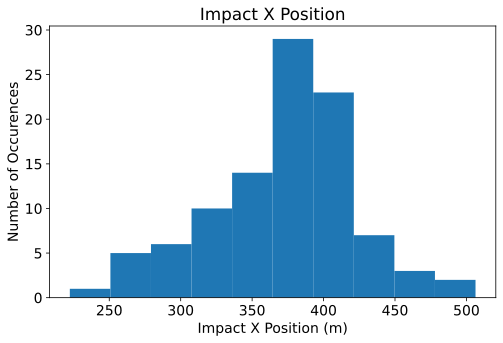

In [15]:
print(
    f'Impact X Position -         Mean Value: {np.mean(dispersion_results["impact_x"]):0.3f} m'
)
print(
    f'Impact X Position - Standard Deviation: {np.std(dispersion_results["impact_x"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["impact_x"], bins=int(N**0.5))
plt.title("Impact X Position")
plt.xlabel("Impact X Position (m)")
plt.ylabel("Number of Occurences")
plt.show()

### Impact Y Position

Impact Y Position -         Mean Value: 0.993 m
Impact Y Position - Standard Deviation: 34.913 m


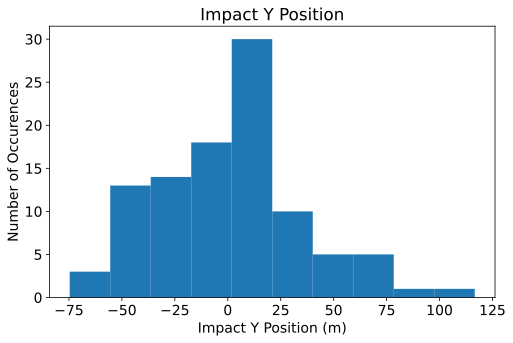

In [16]:
print(
    f'Impact Y Position -         Mean Value: {np.mean(dispersion_results["impact_y"]):0.3f} m'
)
print(
    f'Impact Y Position - Standard Deviation: {np.std(dispersion_results["impact_y"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["impact_y"], bins=int(N**0.5))
plt.title("Impact Y Position")
plt.xlabel("Impact Y Position (m)")
plt.ylabel("Number of Occurences")
plt.show()

### Impact Velocity

Impact Velocity -         Mean Value: -17.198 m/s
Impact Velocity - Standard Deviation: 1.352 m/s


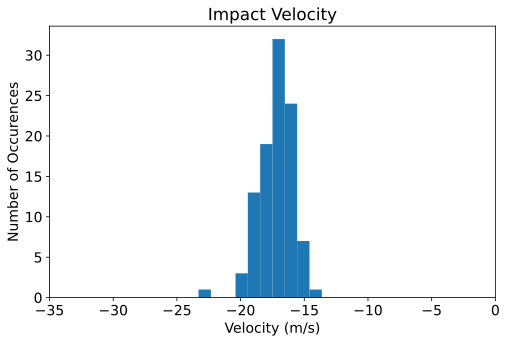

In [17]:
print(
    f'Impact Velocity -         Mean Value: {np.mean(dispersion_results["impact_velocity"]):0.3f} m/s'
)
print(
    f'Impact Velocity - Standard Deviation: {np.std(dispersion_results["impact_velocity"]):0.3f} m/s'
)

plt.figure()
plt.hist(dispersion_results["impact_velocity"], bins=int(N**0.5))
plt.title("Impact Velocity")
# plt.grid()
plt.xlim(-35, 0)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Number of Occurences")
plt.show()

### Static Margin

Initial Static Margin -             Mean Value: 2.650 c
Initial Static Margin -     Standard Deviation: 0.336 c
Out of Rail Static Margin -         Mean Value: 2.851 c
Out of Rail Static Margin - Standard Deviation: 0.338 c
Final Static Margin -               Mean Value: 3.795 c
Final Static Margin -       Standard Deviation: 0.357 c


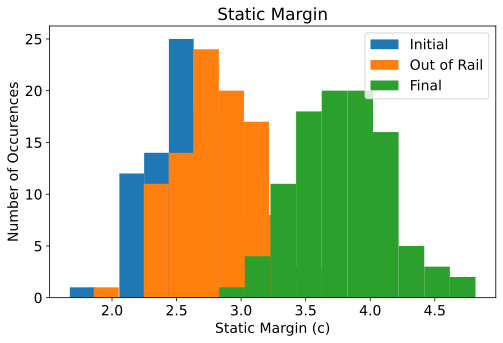

In [18]:
print(
    f'Initial Static Margin -             Mean Value: {np.mean(dispersion_results["initial_static_margin"]):0.3f} c'
)
print(
    f'Initial Static Margin -     Standard Deviation: {np.std(dispersion_results["initial_static_margin"]):0.3f} c'
)

print(
    f'Out of Rail Static Margin -         Mean Value: {np.mean(dispersion_results["out_of_rail_static_margin"]):0.3f} c'
)
print(
    f'Out of Rail Static Margin - Standard Deviation: {np.std(dispersion_results["out_of_rail_static_margin"]):0.3f} c'
)

print(
    f'Final Static Margin -               Mean Value: {np.mean(dispersion_results["final_static_margin"]):0.3f} c'
)
print(
    f'Final Static Margin -       Standard Deviation: {np.std(dispersion_results["final_static_margin"]):0.3f} c'
)

plt.figure()
plt.hist(dispersion_results["initial_static_margin"], label="Initial", bins=int(N**0.5))
plt.hist(
    dispersion_results["out_of_rail_static_margin"],
    label="Out of Rail",
    bins=int(N**0.5),
)
plt.hist(dispersion_results["final_static_margin"], label="Final", bins=int(N**0.5))
plt.legend()
plt.title("Static Margin")
plt.xlabel("Static Margin (c)")
plt.ylabel("Number of Occurences")
plt.show()

### Maximum Velocity

Maximum Velocity -         Mean Value: 123.945 m/s
Maximum Velocity - Standard Deviation: 5.679 m/s


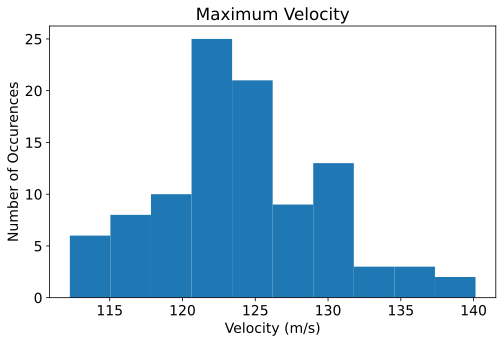

In [19]:
print(
    f'Maximum Velocity -         Mean Value: {np.mean(dispersion_results["max_velocity"]):0.3f} m/s'
)
print(
    f'Maximum Velocity - Standard Deviation: {np.std(dispersion_results["max_velocity"]):0.3f} m/s'
)

plt.figure()
plt.hist(dispersion_results["max_velocity"], bins=int(N**0.5))
plt.title("Maximum Velocity")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Number of Occurences")
plt.show()

### Number of Parachute Events

This is usefull to check if the parachute was triggered in every flight.

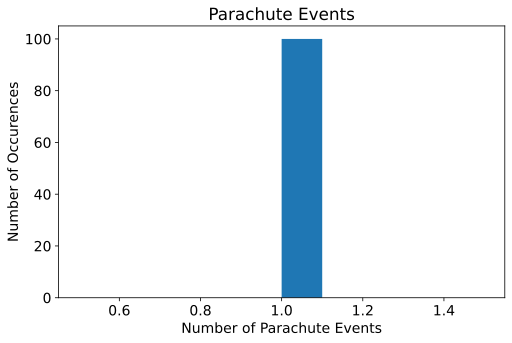

In [20]:
plt.figure()
plt.hist(dispersion_results["number_of_events"])
plt.title("Parachute Events")
plt.xlabel("Number of Parachute Events")
plt.ylabel("Number of Occurences")
plt.show()

### Drogue Parachute Trigger Time

Drogue Parachute Trigger Time -         Mean Value: 14.280 s
Drogue Parachute Trigger Time - Standard Deviation: 0.353 s


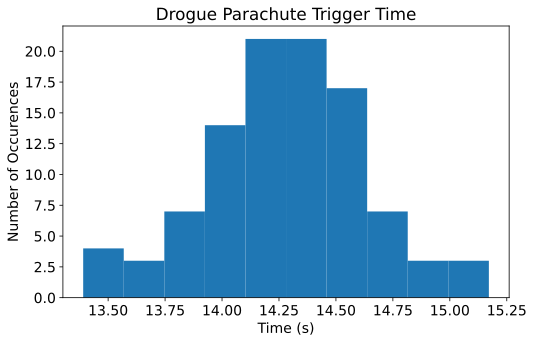

In [21]:
print(
    f'Drogue Parachute Trigger Time -         Mean Value: {np.mean(dispersion_results["drogue_triggerTime"]):0.3f} s'
)
print(
    f'Drogue Parachute Trigger Time - Standard Deviation: {np.std(dispersion_results["drogue_triggerTime"]):0.3f} s'
)

plt.figure()
plt.hist(dispersion_results["drogue_triggerTime"], bins=int(N**0.5))
plt.title("Drogue Parachute Trigger Time")
plt.xlabel("Time (s)")
plt.ylabel("Number of Occurences")
plt.show()

### Drogue Parachute Fully Inflated Time

Drogue Parachute Fully Inflated Time -         Mean Value: 16.101 s
Drogue Parachute Fully Inflated Time - Standard Deviation: 0.662 s


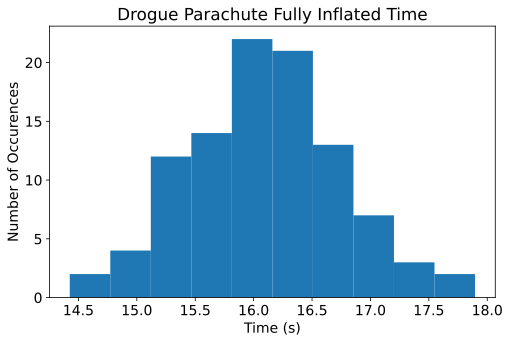

In [22]:
print(
    f'Drogue Parachute Fully Inflated Time -         Mean Value: {np.mean(dispersion_results["drogue_inflated_time"]):0.3f} s'
)
print(
    f'Drogue Parachute Fully Inflated Time - Standard Deviation: {np.std(dispersion_results["drogue_inflated_time"]):0.3f} s'
)

plt.figure()
plt.hist(dispersion_results["drogue_inflated_time"], bins=int(N**0.5))
plt.title("Drogue Parachute Fully Inflated Time")
plt.xlabel("Time (s)")
plt.ylabel("Number of Occurences")
plt.show()

### Drogue Parachute Fully Inflated Velocity

Drogue Parachute Fully Inflated Velocity -         Mean Value: 20.098 m/s
Drogue Parachute Fully Inflated Velocity - Standard Deviation: 3.898 m/s


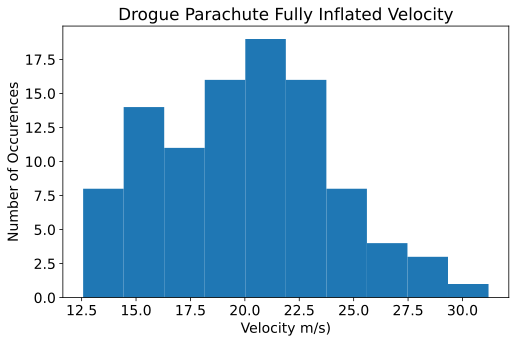

In [23]:
print(
    f'Drogue Parachute Fully Inflated Velocity -         Mean Value: {np.mean(dispersion_results["drogue_inflated_velocity"]):0.3f} m/s'
)
print(
    f'Drogue Parachute Fully Inflated Velocity - Standard Deviation: {np.std(dispersion_results["drogue_inflated_velocity"]):0.3f} m/s'
)

plt.figure()
plt.hist(dispersion_results["drogue_inflated_velocity"], bins=int(N**0.5))
plt.title("Drogue Parachute Fully Inflated Velocity")
plt.xlabel("Velocity m/s)")
plt.ylabel("Number of Occurences")
plt.show()

### Error Ellipses


C:\Users\GiovaniCeotto\AppData\Local\Temp\ipykernel_20108\290763576.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread("dispersion_analysis_inputs/Valetudo_basemap_final.jpg")


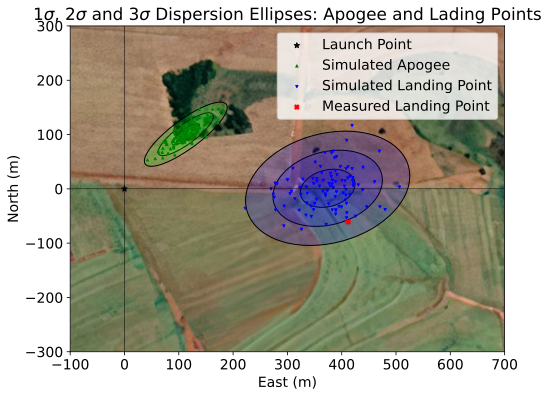

In [24]:
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

# Import background map
img = imread("monte_carlo_analysis_inputs/Valetudo_basemap_final.jpg")

# Retrieve dispersion data por apogee and impact XY position
apogee_x = np.array(dispersion_results["apogee_x"])
apogee_y = np.array(dispersion_results["apogee_y"])
impact_x = np.array(dispersion_results["impact_x"])
impact_y = np.array(dispersion_results["impact_y"])


# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]


# Create plot figure
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor="w", edgecolor="k")
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impact_x, impact_y)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:, 0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
impact_ellipses = []
for j in [1, 2, 3]:
    impactEll = Ellipse(
        xy=(np.mean(impact_x), np.mean(impact_y)),
        width=impactW * j,
        height=impactH * j,
        angle=impactTheta,
        color="black",
    )
    impactEll.set_facecolor((0, 0, 1, 0.2))
    impact_ellipses.append(impactEll)
    ax.add_artist(impactEll)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogee_x, apogee_y)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:, 0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
for j in [1, 2, 3]:
    apogeeEll = Ellipse(
        xy=(np.mean(apogee_x), np.mean(apogee_y)),
        width=apogeeW * j,
        height=apogeeH * j,
        angle=apogeeTheta,
        color="black",
    )
    apogeeEll.set_facecolor((0, 1, 0, 0.2))
    ax.add_artist(apogeeEll)

# Draw launch point
plt.scatter(0, 0, s=30, marker="*", color="black", label="Launch Point")
# Draw apogee points
plt.scatter(
    apogee_x, apogee_y, s=5, marker="^", color="green", label="Simulated Apogee"
)
# Draw impact points
plt.scatter(
    impact_x, impact_y, s=5, marker="v", color="blue", label="Simulated Landing Point"
)
# Draw real landing point
plt.scatter(
    411.89, -61.07, s=20, marker="X", color="red", label="Measured Landing Point"
)

plt.legend()

# Add title and labels to plot
ax.set_title(
    "1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Lading Points"
)
ax.set_ylabel("North (m)")
ax.set_xlabel("East (m)")

# Add background image to plot
# You can translate the basemap by changing dx and dy (in meters)
dx = 0
dy = 0
plt.imshow(img, zorder=0, extent=[-1000 - dx, 1000 - dx, -1000 - dy, 1000 - dy])
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.xlim(-100, 700)
plt.ylim(-300, 300)

# Save plot and show result
plt.savefig(str(filename) + ".pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(str(filename) + ".svg", bbox_inches="tight", pad_inches=0)
plt.show()